# Загрузка библиотек

In [1]:
import math
import numpy as np
import scipy.stats as sps
from numpy import linalg as LA


import pandas as pd

from collections import deque
from functools import partial
import time

# import sklearn.datasets as skldata


import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({"font.family": "Helvetica"})
sns.set_context("talk")
sns.set(font_scale=1.3, palette='Set2')

# Общие стандартные методы гладкой оптимизации

Самый обычный градиентный спуск, можно менять скорость от номера итерации, а также критерий остановки

In [128]:
def gradient_descent(f, nabla_f, x_0, lr,
                     K = 10**4, eps = 10**-6, criteria=0,
                    time_history=True, oracle_calls=True):
    '''
        f - целевая функция
        nabla_f - градиент целевой функции
        x_0 - стартовая точка
        lr - функция для вычисления шага метода
        K - количество итераций (по умолчанию 1е3)
        eps - желаемая точность (по умолчанию 1е-5)
        time_history - True\False: возвращать историю по времени или нет
        oracle_calls - True\False: возвращать историю по вызовам оракула или нет

        Функция возвращает точку, в которой достигается минимум и вектор ошибок
    '''
    time_arr = []
    errors_arr = []
    oracle_arr = [0]

    x = x_0

    k = 1

    start_time = time.time()

    while True:
      if oracle_calls:
        grad, new_calls = nabla_f(x)
        oracle_arr.append(oracle_arr[-1] + new_calls)
      else:
        grad = nabla_f(x)

      x_1 = x - lr(k) * grad


      error = criteria(x_1)

      errors_arr.append(error)

      x = x_1

      k += 1

      if time_history:
        time_arr.append(time.time() - start_time)

      if error < eps:
        break

      if k > K:
        break

    if time_history:
      if oracle_calls:
        return x, np.array(errors_arr), np.array(time_arr), np.array(oracle_arr[1:])
      else:
        return x, np.array(errors_arr), np.array(time_arr)
    else:
      if oracle_calls:
        return x, np.array(errors_arr), np.array(oracle_arr[1:])
      else:
        return x, np.array(errors_arr)

Метод ускоренного градиентного спуска (Нестеров), можно менять скорость и момент от номера итерации, а также критерий остановки

In [129]:
def nesterov_gradient_descent(f, nabla_f, x_0, lr, tau,
                     K = 10**3, eps = 10**-6, criteria=0,
                              time_history=True, oracle_calls=True):
    '''
        f - целевая функция
        nabla_f - градиент целевой функции
        x_0 - стартовая точка
        lr - функция для вычисления шага метода
        tau - функция для вычисления шага моментума метода
        K - количество итераций (по умолчанию 1е3)
        eps - желаемая точность (по умолчанию 1е-5)
        time_history - True\False: возвращать историю по времени или нет
        oracle_calls - True\False: возвращать историю по вызовам оракула или нет

        Функция возвращает точку, в которой достигается минимум и вектор ошибок
    '''


    time_arr = []
    errors_arr = []
    oracle_arr = [0]
    x = x_0
    y = x_0
    x_1 = x_0
    y_1 = x_0


    k = 1
    start_time = time.time()
    while True:

      if oracle_calls:
        grad, new_calls = nabla_f(x)
        oracle_arr.append(oracle_arr[-1] + new_calls)
      else:
        grad = nabla_f(x)

      x_1 = y - lr(k) *  grad
      y_1 = x_1 + tau(k) * (x_1 - x)


      error = criteria(x_1)

      errors_arr.append(error)

      x = x_1
      y = y_1

      k += 1

      if time_history:
        time_arr.append(time.time() - start_time)

      if error < eps:
        break

      if k > K:
        break

    if time_history:
      if oracle_calls:
        return x, np.array(errors_arr), np.array(time_arr), np.array(oracle_arr[1:])
      else:
        return x, np.array(errors_arr), np.array(time_arr)
    else:
      if oracle_calls:
        return x, np.array(errors_arr), np.array(oracle_arr[1:])
      else:
        return x, np.array(errors_arr)

Метод ADAM, можно менять скорость от номера итерации, а также критерий остановки

# Общие функции для приближения градиента

Варианты приближения градиента:

Central finite difference (Central)
 $$\nabla f_{\gamma} (x, e) = d \frac{f (x + \gamma e) - f (x - \gamma e)}{2 \gamma} e \qquad (2)$$

Forward finite difference (Forward)
$$\nabla f_{\gamma} (x, e) = d \frac{f (x + \gamma e) - f (x)}{\gamma} e. \qquad (14)$$


In [130]:
def sample_spherical(npoints, d=3):
  '''
        npoints -  кол-во точек, которое хотим получить
        d - размерность сферы

        Функция возвращает npoints случайных точек на сфере S^d_2 единичного радиуса с центром в нуле
  '''
  vec = np.random.randn(d, npoints)
  vec /= np.linalg.norm(vec, axis=0)
  return vec

In [131]:
def central_gradient_approximation_direction(oracul, gamma, x, e):
  '''
        oracul - оракул, который возвращает значения в 2 точках для одного значения случайной величины
        gamma - окрестность
        x - точка
        e - вектор, по которому ищем градиент

        Функция возвращает градиент
    '''
  assert(gamma != 0)
  assert(x.shape == e.shape)
  points = np.concatenate((x - gamma * e, x + gamma * e),axis=1)
  values = oracul.get_two_values(points)
  return x.shape[0] * (values[1] - values[0]) / (2 * gamma) * e

In [132]:
def forward_gradient_approximation_direction(oracul, gamma, x, e):
  '''
        oracul - оракул, который возвращает значения в 2 точках для одного значения случайной величины
        gamma - окрестность
        x - точка
        e - вектор, по которому ищем градиент

        Функция возвращает градиент
    '''
  assert(gamma != 0)
  assert(x.shape == e.shape)
  points = np.concatenate((x, x + gamma * e),axis=1)
  values = oracul.get_two_values(points)
  return x.shape[0] * (values[1] - values[0]) / (2 * gamma) * e

Central подход: считаем для $e \sim RS_d^2(1)$ -- случайный вектор с равномерным распределением на сфере.

Координатный Central подход: для $e^{all} \sim RS_d^2(1)$ -- случайный вектор с равномерным распределением на сфере отдельно считаем для всех $i$ значение в $e = (0, \ldots e^{all}_i, \ldots  0)^T$, где на $i$-той позиции $e^{all}_i$.

In [133]:
np.diagflat(np.array([[1, 2, 3]]).T)

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [134]:
def gradient_approximation_central(oracul, gamma, x, coordinates=False, num_calls=False):
    '''
        oracul - оракул, который возвращает значения в 2 точках для одного значения случайной величины
        gamma - окрестность
        x - точка
        coordinates - True\False, считать отдельно по каждому направлению или нет
        num_calls - True\False, считать кол-во вызовов оракула или нет
        Функция возвращает приближение градиента
    '''
    assert(gamma != 0)

    d = x.shape[0]
    e_all = sample_spherical(1, d)
    if not coordinates:
      grad = central_gradient_approximation_direction(oracul, gamma, x, e_all)
      if num_calls:
        return grad, 2
      else:
        return grad

    grads = 0
    for i in range(d):
      e = np.zeros(x.shape)
      e[i, 0] = e_all[i, 0]
      grads += central_gradient_approximation_direction(oracul, gamma, x, e)
    if num_calls:
      return grads, 2 * d
    else:
      return grads

Координатный Forward подход: считаем для $e \sim RS_d^2(1)$ -- случайный вектор с равномерным распределением на сфере.

Координатный Forward подход: для $e^{all} \sim RS_d^2(1)$ -- случайный вектор с равномерным распределением на сфере отдельно считаем для всех $i$ значение в $e = (0, \ldots e^{all}_i, \ldots  0)^T$, где на $i$-той позиции $e^{all}_i$.

In [135]:
def gradient_approximation_forward(oracul, gamma, x, coordinates=False, num_calls=False):
    '''
        oracul - оракул, который возвращает значение в 1 точке
        gamma - окрестность
        x - точка
        coordinates - True\False, считать отдельно по каждому направлению или нет
        num_calls - True\False, считать кол-во вызовов оракула или нет
        Функция возвращает приближение градиента
    '''
    assert(gamma != 0)

    d = x.shape[0]

    e_all = sample_spherical(1, d)
    if not coordinates:
      e = sample_spherical(1, d)
      grad = forward_gradient_approximation_direction(oracul, gamma, x,
                                                    e_all)
      if num_calls:
        return grad, 2
      else:
        return grad

    grads = 0
    for i in range(d):
      e = np.zeros(x.shape)
      e[i, 0] = e_all[i, 0]
      grads += forward_gradient_approximation_direction(oracul, gamma, x, e)
    if num_calls:
      return grads, 2 * d
    else:
      return grads

# Функции для графиков

In [83]:
def get_max_min_values(list_of_arr):
  '''
        list_of_arr -- список np.arrays одинаковой формы (n, )

        Функция возвращает 2 np.arrays: с минимальным значением из всех np.arrays
        на позиции i и с максимальным значением на позиции.
  '''
  all_arr = np.array(list_of_arr)
  return np.min(all_arr, axis=0), np.max(all_arr, axis=0)

In [151]:
def plot_loss_by_step_intervals(errors_lists, names_list, title=None):
  assert(len(errors_lists) == len(names_list))
  plt.figure(figsize=(12, 6))

  for i in range(len(names_list)):
    all_errors =  np.array(errors_lists[i])
    if all_errors.ndim == 1:
      plt.plot(np.arange(len(errors_lists[i])), errors_lists[i], label=names_list[i])
    else:
      plt.fill_between(np.arange(all_errors.shape[1]), np.min(all_errors, axis=0),
                       np.max(all_errors, axis=0), alpha=0.3)
      plt.plot(np.arange(all_errors.shape[1]), np.mean(all_errors, axis=0), label=names_list[i])

  plt.legend()

  plt.yscale('log')

  plt.xlabel('Номер итерации')
  plt.ylabel('Значения функции потерь')

  if title == None:
    plt.title('Сходимость для разных методов аппроксимации градиента', fontsize=20)
  else:
    plt.title(title, fontsize=20)
  plt.show()

In [88]:
def plot_loss_by_step(errors_lists, names_list, title=None):
  assert(len(errors_lists) == len(names_list))
  plt.figure(figsize=(12, 6))

  for i in range(len(names_list)):
    plt.plot(np.arange(len(errors_lists[i])), errors_lists[i], label=names_list[i])

  plt.legend()

  plt.yscale('log')

  plt.xlabel('Номер итерации')
  plt.ylabel('Значения функции потерь')

  if title == None:
    plt.title('Сходимость для разных методов аппроксимации градиента', fontsize=20)
  else:
    plt.title(title, fontsize=20)
  plt.show()

In [173]:
def plot_loss_by_time_intervals(time_lists, errors_lists, names_list, title=None):
  assert(len(errors_lists) == len(names_list))
  assert(len(errors_lists) == len(time_lists))
  plt.figure(figsize=(12, 6))

  colors = ['b', 'c', 'g', 'm', 'r', 'y']

  n_methods = len(names_list)
  n_runs = len(time_lists[0])

  for j in range(n_runs):
    for i in range(n_methods):
      plt.plot(time_lists[i][j], errors_lists[i][j],
                alpha=0.3, color=colors[i],
                label=names_list[i])

  h, l = plt.gca().get_legend_handles_labels()

  plt.legend(h[:n_methods], l[:n_methods])

  plt.yscale('log')

  plt.xlabel('Время, с')
  plt.ylabel('Значения функции потерь')

  if title == None:
    plt.title('Сходимость для разных методов аппроксимации градиента', fontsize=20)
  else:
    plt.title(title, fontsize=20)
  plt.show()

In [89]:
def plot_loss_by_time(time_lists, errors_lists, names_list, title=None):
  assert(len(errors_lists) == len(names_list))
  assert(len(errors_lists) == len(time_lists))
  plt.figure(figsize=(12, 6))

  for i in range(len(names_list)):
    plt.plot(time_lists[i], errors_lists[i], label=names_list[i])

  plt.legend()

  plt.yscale('log')

  plt.xlabel('Время, с')
  plt.ylabel('Значения функции потерь')

  if title == None:
    plt.title('Сходимость для разных методов аппроксимации градиента', fontsize=20)
  else:
    plt.title(title, fontsize=20)
  plt.show()

In [90]:
def plot_loss_by_oracle_calls(calls_lists, errors_lists, names_list, title=None):
  assert(len(errors_lists) == len(names_list))
  assert(len(errors_lists) == len(calls_lists))
  plt.figure(figsize=(12, 6))

  for i in range(len(names_list)):
    plt.plot(calls_lists[i], errors_lists[i], label=names_list[i])

  plt.legend()

  plt.yscale('log')

  plt.xlabel('Кол-во вызовов оракула')
  plt.ylabel('Значения функции потерь')

  if title == None:
    plt.title('Сходимость для разных методов аппроксимации градиента', fontsize=20)
  else:
    plt.title(title, fontsize=20)
  plt.show()

In [176]:
def plot_loss_by_oracle_calls_intervals(calls_lists, errors_lists, names_list, title=None):
  assert(len(errors_lists) == len(names_list))
  assert(len(errors_lists) == len(calls_lists))
  plt.figure(figsize=(12, 6))

  colors = ['b', 'c', 'g', 'm', 'r', 'y']

  n_methods = len(names_list)
  n_runs = len(calls_lists[0])

  for j in range(n_runs):
    for i in range(n_methods):
      plt.plot(calls_lists[i][j], errors_lists[i][j],
                alpha=0.3, color=colors[i],
                label=names_list[i])

  h, l = plt.gca().get_legend_handles_labels()

  plt.legend(h[:n_methods], l[:n_methods])

  plt.yscale('log')

  plt.xlabel('Кол-во вызовов оракула')
  plt.ylabel('Значения функции потерь')

  if title == None:
    plt.title('Сходимость для разных методов аппроксимации градиента', fontsize=20)
  else:
    plt.title(title, fontsize=20)
  plt.show()

# LAD Regression

## Загрузка данных

In [ ]:
def replace_categories(df):
  encoder = {'I': 0, 'F': 1, 'M': 2}
  df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: encoder[x])
  return df

In [ ]:
dataset = 'abalone_train.csv'

In [ ]:
data = pd.read_csv(dataset, header=None)

data = replace_categories(data)
X, y = data.iloc[:, 0:-1].to_numpy(), data.iloc[:, -1].to_numpy()

<ipython-input-17-239415b96ca5>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: encoder[x])


we divide dataset "abalone scale" into two parts, where the part for training is 3500 samples. The dimension of features equals to 8. So, it is a very small dataset. We take dataset with such small dimension to compare Forward and Central with their variants of coordinate steps that depend on dimension.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Функция потерь и оракул 0-порядка

Least absolute deviation (LAD) regression
$$\min_{w \in R^d} \{f (w) = \frac{1}{m} \sum^m_{k=1}|x^T_k w - y_k|\} \qquad \mbox{негладкая функция}$$
задача оптимизации с конечной суммой


Оракул нулевого порядка, который выдает значения в 1 или 2 точках (для одного $i$) за один запрос.

In [ ]:
class LADZeroOrderOracul:
  def __init__(self, X, y):
    assert(X.shape[0] == y.shape[0])
    self.X = X
    self.y = y

  def get_one_value(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    i = np.random.randint(self.X.shape[0], size=1)
    return np.abs(self.X[i] @ w - self.y[i])[0, 0]

  def get_two_values(self, w):
    assert(w.shape == (self.X.shape[1], 2))
    i = np.random.randint(self.X.shape[0], size=1)
    return np.abs(self.X[i] @ w - self.y[i])[0]

  def get_total_loss(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    return np.mean(np.abs(self.X @ w - self.y))

  def get_total_grad(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    preds = self.X @ w
    signs  = 2 * (preds > self.y) - 1
    return np.mean(self.X * signs, axis=0).reshape((-1,1))

Функция потерь и градиент всей функции потерь для экспериментов

## Нахождение $\gamma$

$M_2$  -- константа Липшица для функции $f$ и нормы $2$:

$|f (w_2) - f (w_1)| \leq M_2 ||w_2 - w_1||_2$ на $Q_\gamma$

$\frac{1}{m} \sum^m_{k=1}(|x^T_k w_2 - y_i| - |x^T_k w_1 - y_i|) \leq \frac{1}{m} \sum^m_{k=1} |x^T_k (w_2 - w_1)| \leq $

$M_2 = \max \{ |x_i^j| \; | \; 1 \leq i \leq m, \; 1 \leq j \leq d \}$

$\varepsilon $ -- точность, с которой хотим решить

Тогда берем $\gamma = \varepsilon/(2 M_2)$

In [ ]:
eps = 1e-3
M2 = np.max(np.abs(X_train))
lad_gamma = eps / (2 * M2)
print(lad_gamma)

0.0001769598301185631


## Эксперимент

In [ ]:
lad_oracul_train = LADZeroOrderOracul(X_train, y_train.reshape((-1, 1)))
lad_oracul_val = LADZeroOrderOracul(X_val, y_val.reshape((-1, 1)))
f = lambda w: lad_oracul_train.get_total_loss(w)
criteria = lambda w: lad_oracul_val.get_total_loss(w)

### Несколько тестов работы Оракула

In [ ]:
w  = np.ones((8, 2))
w[:, 1] = 1.05

In [ ]:
lad_oracul_train.get_two_values(w)

array([1.487  , 1.71135])

In [ ]:
w  = np.ones((8, 1))
lad_oracul_train.get_total_grad(w)

array([[1.01356203],
       [0.43866374],
       [0.34299761],
       [0.1171799 ],
       [0.7537874 ],
       [0.32893319],
       [0.16462704],
       [0.21553889]])

In [ ]:
criteria(w)

1.7957126047068208

In [ ]:
lad_oracul_train.get_total_loss(np.ones((8, 1)))

1.7957126047068208

In [ ]:
w_0 = np.random.uniform(0, 1,(8, 1))
gradient_approximation_central(lad_oracul_train, lad_gamma, w_0)

array([[ 2.42734576],
       [ 0.33008411],
       [ 0.7058576 ],
       [ 4.9638564 ],
       [ 3.27118403],
       [-0.72989717],
       [ 0.68347454],
       [-2.95734786]])

### Градиентный спуск

In [ ]:
nablas = {'central_coord': lambda w: gradient_approximation_central(lad_oracul_train, lad_gamma, w, True, True),
          'forward_coord': lambda w: gradient_approximation_forward(lad_oracul_train, lad_gamma, w, True, True),
          'central': lambda w: gradient_approximation_central(lad_oracul_train, lad_gamma, w, False, True),
          'forward': lambda w: gradient_approximation_forward(lad_oracul_train, lad_gamma, w, False, True),
          'gradient': lambda w: lad_oracul_train.get_total_grad(w)}
errors = {'central_coord': [], 'forward_coord': [],
          'central': [], 'forward': [], 'gradient': []}
times = {'central_coord': [], 'forward_coord': [],
         'central': [], 'forward': [], 'gradient': []}
oracle_calls = {'central_coord': [], 'forward_coord': [],
         'central': [], 'forward': []}
lrs = {'central_coord': 0.01, 'forward_coord': 0.01,
       'central': 0.01, 'forward': 0.01, 'gradient': 0.01}

In [ ]:
seeds = [0, 1, 2]

In [ ]:
w_0 = np.zeros((X_train.shape[1], 1))
# np.random.uniform(0, 1,(X_train.shape[1], 1))

for method_name in errors.keys():
  nabla_f = nablas[method_name]
  for seed in seeds:
    if method_name == 'gradient':
      w_opt, error, iter_time = gradient_descent(f, nabla_f, w_0,
                                      lr = lambda k: 0.001,
                                      K = 10**4, eps=eps,
                                      criteria=criteria, time_history=True, oracle_calls=False)

    else:
      w_opt, error, iter_time, oracle_call = gradient_descent(f, nabla_f, w_0,
                                      lr = lambda k: 0.001,
                                      K = 10**4, eps=eps,
                                      criteria=criteria, time_history=True, oracle_calls=True)
      oracle_calls[method_name].append(oracle_call)

    errors[method_name].append(error)
    times[method_name].append(iter_time)

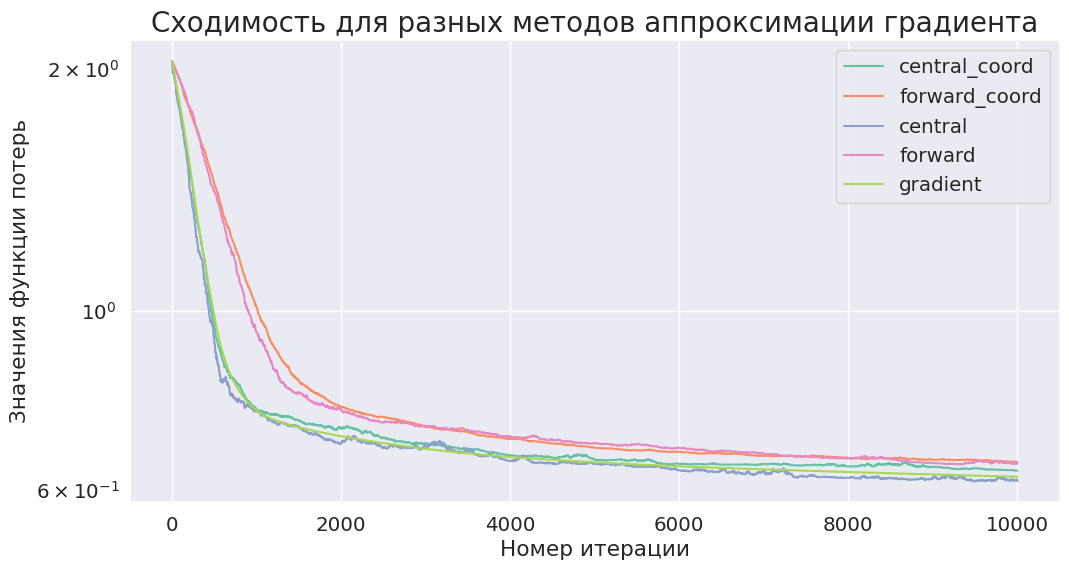

In [ ]:
plot_loss_by_step(list(errors.values()), list(errors.keys()))

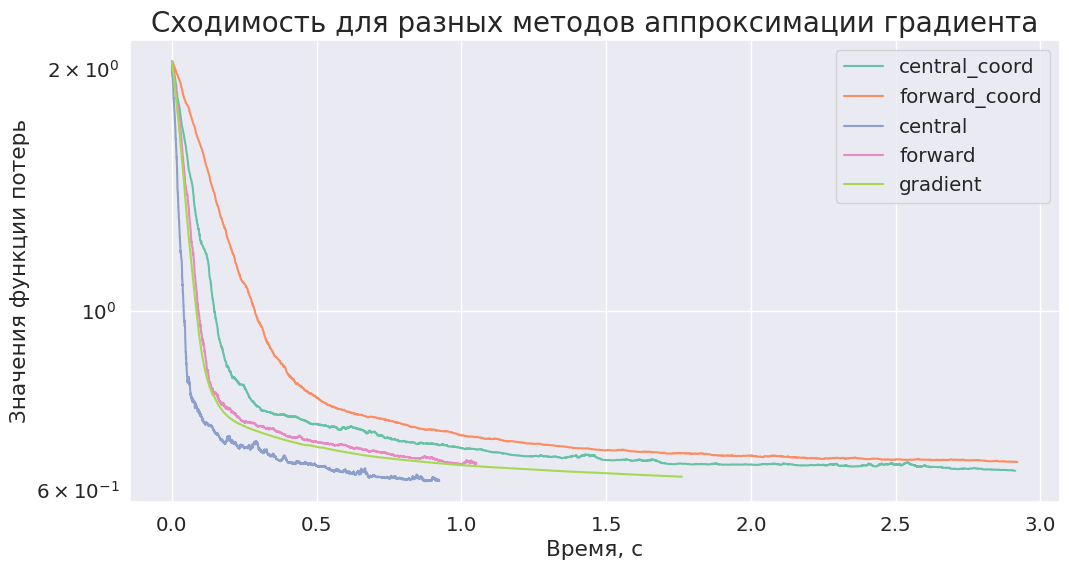

In [ ]:
plot_loss_by_time(list(times.values()), list(errors.values()), list(errors.keys()))

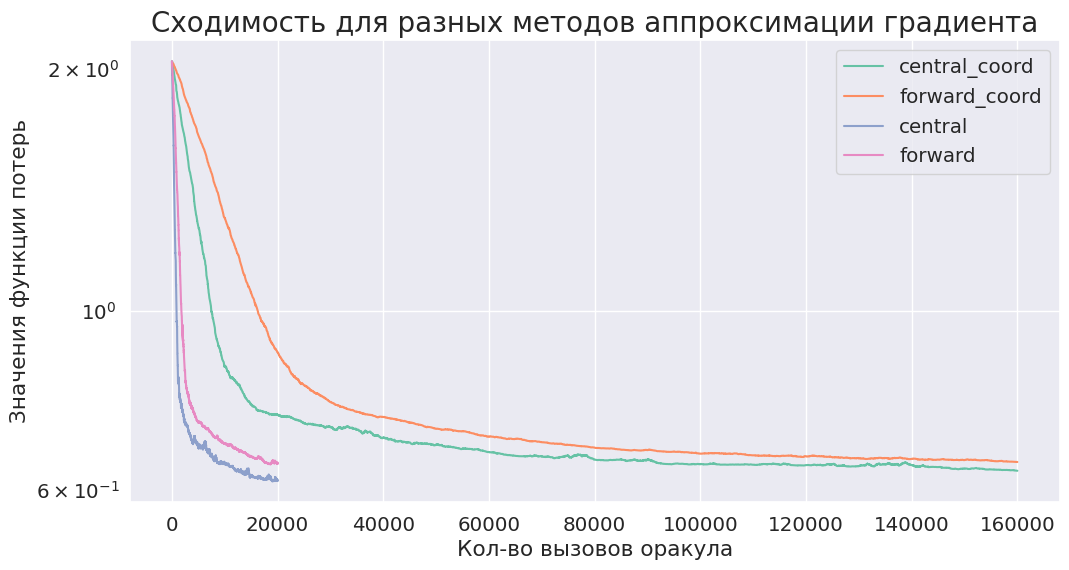

In [ ]:
plot_loss_by_oracle_calls(list(oracle_calls.values()), list(errors.values())[:-1], list(errors.keys())[:-1])

Вывод: оба метода аппроксимации градиента гораздо быстрее градиентного спуска, при этом находят почти такие же результаты.

### Метод Нестерова

In [ ]:
w_0 = np.zeros((X_train.shape[1], 1))
# np.random.uniform(0, 1,(X_train.shape[1], 1))

for method_name in errors.keys():
  nabla_f = nablas[method_name]
  if method_name == 'gradient':
    w_opt, errors[method_name], times[method_name] = gradient_descent(f, nabla_f, w_0,
                                    lr = lambda k: 0.001,
                                    K = 10**4, eps=eps,
                                    criteria=criteria, time_history=True, oracle_calls=False)
  else:
    w_opt, errors[method_name], times[method_name], oracle_calls[method_name] = nesterov_gradient_descent(f, nabla_f, w_0,
                                    lr = lambda k: 0.001, tau = lambda k: 0.01,
                                    K = 10**4, eps=eps,
                                    criteria=criteria, time_history=True, oracle_calls=True)

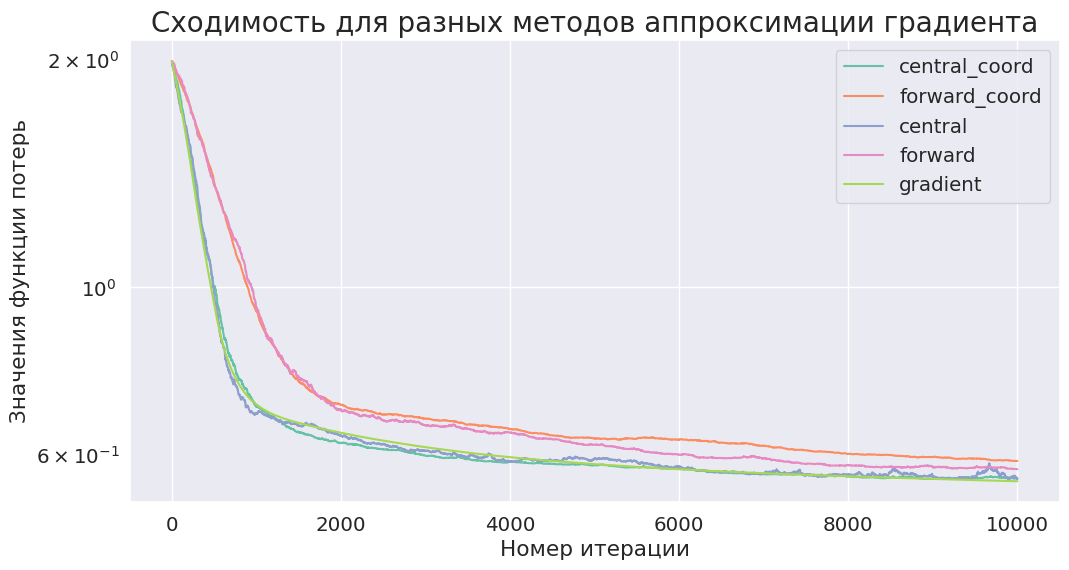

In [ ]:
plot_loss_by_step(list(errors.values()), list(errors.keys()))

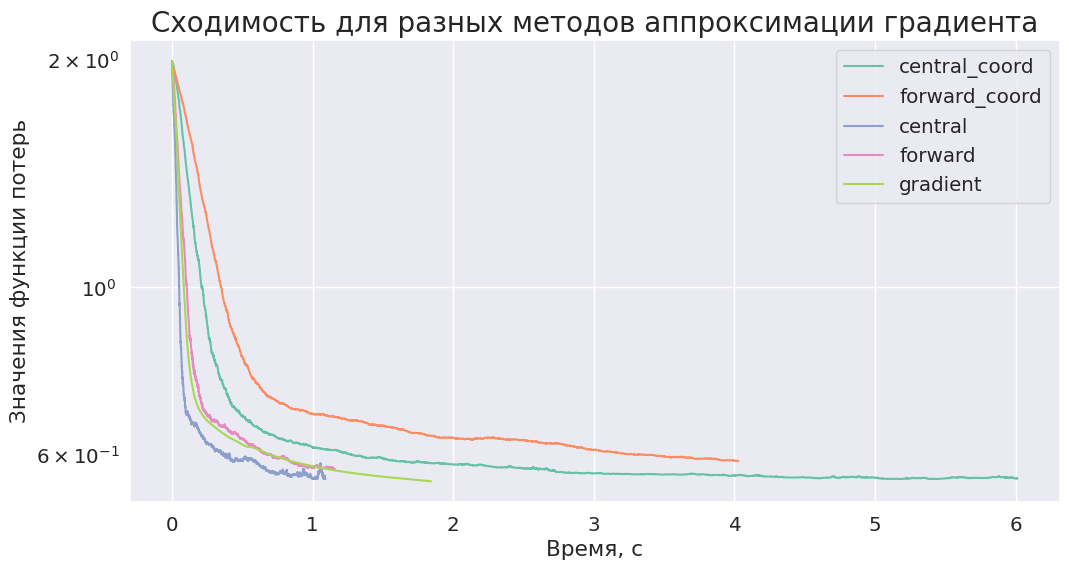

In [ ]:
plot_loss_by_time(list(times.values()), list(errors.values()), list(errors.keys()))

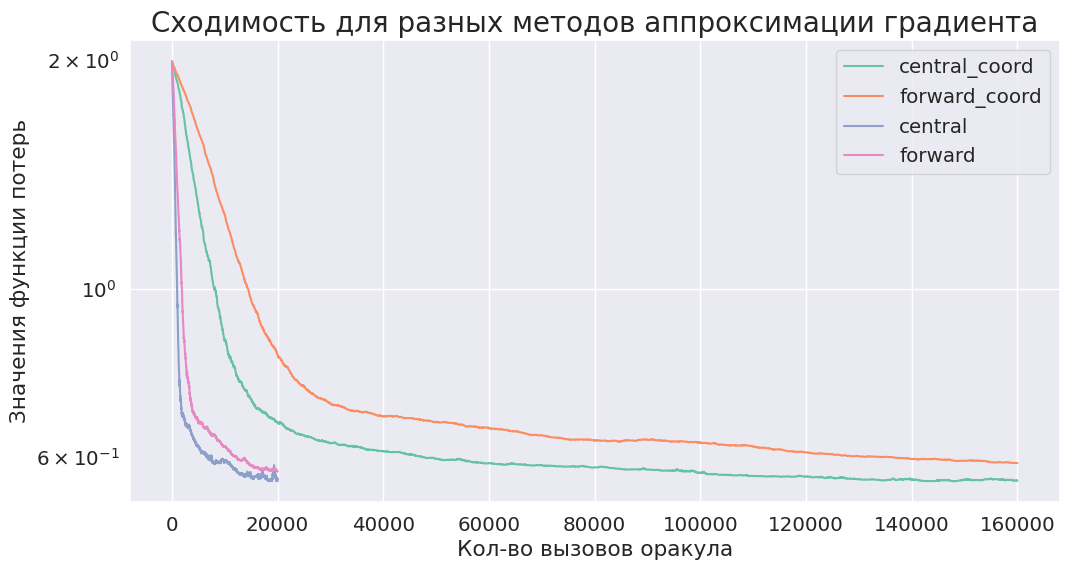

In [ ]:
plot_loss_by_oracle_calls(list(oracle_calls.values()), list(errors.values())[:-1], list(errors.keys())[:-1])

### Метод Адам

# SVM

## Загрузка данных

### Преобразуем файлы с данными в csv

In [ ]:
import re

def writeFile(inputfile, outpufile, instances):
  wf = open(outpufile, 'w')


  with open(inputfile) as rf:
    for line in rf:
      values = [0.0] * (instances + 1)
      matches = re.findall('(\d+):(\d+)', line, re.DOTALL)
      values[-1] = 0 if line[0] == '-' else 1

      for index, value in matches:
        values[int(index) - 1] = float(value)

      wf.write(','.join(map(str, values)) + '\n')
      values = [0.0] * (instances + 1)
  wf.close()


In [50]:
# writeFile('a9a.txt', 'a9a.csv', 123)
writeFile('a9a.t', 'a9a_t.csv', 123)

### Читаем данные

In [103]:
data_train = pd.read_csv('a9a.csv', header=None)
X_train = data_train.iloc[:, 1:].to_numpy()
y_train = data_train.iloc[:, 0].to_numpy().reshape((-1,1))
data_train

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
32557,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
32558,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
32559,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [104]:
data_test = pd.read_csv('a9a_t.csv', header=None)
X_test = data_test.iloc[:, 1:].to_numpy()
y_test = data_test.iloc[:, 0].to_numpy().reshape((-1,1))
data_test

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
16277,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
16278,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
16279,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [105]:
np.count_nonzero(X_train==0) / (X_train.shape[0] * X_train.shape[1])

0.8868859773638123

## Функция потерь и оракул 0-порядка

$$ \min_{w \in R^d} \{f (w) = \frac{\mu}{2} ||w||^2_2 + \frac{1}{m} \sum^m_{k=1} (1 - y_i \cdot x^T_i w)_+ \} ,$$

In [182]:
reg = 1e-05

In [183]:
class SVMZeroOrderOracul:
  def __init__(self, X, y, mu=reg):
    assert(X.shape[0] == y.shape[0])
    assert(mu >= 0)
    self.X = X
    self.y = y
    self.mu = mu

  def get_one_value(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    i = np.random.randint(self.X.shape[0], size=1)
    val = 1 - self.y[i] * (self.X[i] @ w)
    reg = self.mu * np.sum(w**2) / 2
    # print(val, val * (val > 0))
    return (reg + np.mean(val * (val > 0)))

  def get_two_values(self, w):
    assert(w.shape == (self.X.shape[1], 2))
    i = np.random.randint(self.X.shape[0], size=1)
    val = 1 - self.y[i] * (self.X[i] @ w)
    reg = self.mu * np.mean(w**2, axis=0) / 2
    return reg + np.mean(val * (val > 0), axis=0) / 2

  def get_total_loss(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    vals = 1 - self.y * (self.X @ w)
    signs = vals > 0
    # print(vals * signs)
    return self.mu * np.sum(w**2) / 2 +  np.mean(vals * signs)

  def get_total_grad(self, w):
    assert(w.shape == (self.X.shape[1], 1))
    vals = 1 - self.y * (self.X @ w)
    signs  = vals > 0
    return self.mu * w + np.mean((-self.y * self.X) * signs, axis=0).reshape((-1, 1))

In [108]:
svm_oracul = SVMZeroOrderOracul(X_train[:10000], y_train[:10000])

In [109]:
w = np.ones((123, 1))

In [110]:
w = np.random.uniform(-2, 2,(123, 1))

In [111]:
w[w < 1]

array([-4.54239412e-01, -5.12092905e-01, -1.97245995e+00, -5.46617652e-01,
        2.16957338e-01,  7.15672781e-01, -1.18109336e+00, -5.74612249e-01,
       -2.32216243e-01, -3.87737568e-01, -1.04106067e+00,  1.13991920e-01,
       -1.89562831e+00, -9.12066150e-01, -6.09382731e-01, -1.48568731e+00,
        6.15027940e-01, -4.63870829e-01, -4.50546157e-01,  2.09783252e-01,
       -1.42724232e+00,  3.52903310e-01, -6.78073394e-01, -1.20692100e+00,
        1.67100653e-01,  2.48798150e-01, -1.07750032e+00,  5.18627433e-01,
        1.25797678e-01,  7.86929325e-01, -8.59344730e-01, -3.82044069e-01,
        6.78008618e-01,  6.88708769e-01, -1.60390119e+00, -2.77984680e-01,
       -1.72463489e+00, -7.49445395e-01,  7.93883163e-01, -1.92974007e+00,
       -6.12812265e-01, -9.30436324e-01,  8.00414416e-01, -8.25835647e-02,
        4.20083434e-01, -5.61217122e-02, -1.33776305e+00, -1.53897759e+00,
       -1.38258965e+00,  6.39719054e-02,  7.46895621e-01, -7.39690561e-01,
       -8.81553637e-01, -

In [112]:
svm_oracul.get_one_value(w)

8.330709393419113

In [113]:
losses = []
for i in range(0, 100):
  losses.append(svm_oracul.get_one_value(w))

In [114]:
(np.array(losses) == 1).sum()

0

In [115]:
w = np.random.uniform(-2, 2,(123, 1))

In [116]:
svm_oracul.get_total_loss(w)

9.308256554342503

In [117]:
svm_oracul.get_one_value(w)

8.851414780419919

In [118]:
np.mean(X_train)

0.11311402263618779

## Нахождение $\gamma$

$M_2$  -- константа Липшица для функции $f$ и нормы $2$:

$|f (w_2) - f (w_1)| \leq M_2 ||w_2 - w_1||_2$ на $Q_\gamma$

$\frac{\mu}{2} ( ||w_2||^2_2 - ||w_1||^2_2 ) + \frac{1}{m} \sum^m_{k=1} \left( (1 - y_i \cdot x^T_i w_2)_+ - (1 - y_i \cdot x^T_i w_1)_+ \right) \leq $

$\leq \frac{\mu}{2} ||w_2 - w_1||^2_2  + \frac{1}{m} \sum^m_{k=1} | y_i \cdot x^T_i \cdot (w_1 - w_2)| \leq \frac{\mu}{2} ||w_2 - w_1||^2_2  + \frac{1}{m} \sum^m_{k=1} || y_i \cdot x^T_i ||_2 \cdot ||w_2 - w_1||_2 $

$M_2 = \frac{\mu}{2} + \frac{1}{m} \sum^m_{k=1} || x_i ||_2$

$\varepsilon $ -- точность, с которой хотим решить

Тогда берем $\gamma = \varepsilon/(2 M_2)$

In [203]:
eps = 1e-09
M2 = reg / 2 + np.mean(np.sqrt(np.sum(X_train**2, axis=1)))
svm_gamma = 1e-5 # eps / (2 * M2)

In [204]:
svm_gamma

1e-05

## Эксперимент

In [205]:
svm_oracul_train = SVMZeroOrderOracul(X_train, y_train)
svm_oracul_test = SVMZeroOrderOracul(X_test, y_test)
f = lambda w: svm_oracul_train.get_total_loss(w)
criteria = lambda w: svm_oracul_test.get_total_loss(w)

In [206]:
nablas = {
          # 'central_coord': lambda w: gradient_approximation_central(svm_oracul_train, svm_gamma, w, True, True),
          # 'forward_coord': lambda w: gradient_approximation_forward(svm_oracul_train, svm_gamma, w, True, True),
          'central': lambda w: gradient_approximation_central(svm_oracul_train, svm_gamma, w, False, True),
          'forward': lambda w: gradient_approximation_forward(svm_oracul_train, svm_gamma, w, False, True),
          'gradient': lambda w: svm_oracul_train.get_total_grad(w)}
errors = {
          # 'central_coord': [], 'forward_coord': [],
          'central': [], 'forward': [],
          'gradient': []}
times = {
        # 'central_coord': [], 'forward_coord': [],
         'central': [], 'forward': [],
         'gradient': []}
oracle_calls = {
    # 'central_coord': [], 'forward_coord': [],
         'central': [], 'forward': []}
lr = 0.1

In [207]:
seeds = [0, 1, 2, 4]

In [208]:
w_0 = np.random.uniform(-2, 2,(123, 1))

for method_name in errors.keys():
  nabla_f = nablas[method_name]
  for seed in seeds:
    print(method_name)
    if method_name == 'gradient':
      w_opt, error, iter_time = gradient_descent(f, nabla_f, w_0,
                                      lr = lambda k: lr,
                                      K = 10**4, eps=eps,
                                      criteria=criteria, time_history=True, oracle_calls=False)

    else:
      w_opt, error, iter_time, oracle_call = gradient_descent(f, nabla_f, w_0,
                                      lr = lambda k: lr,
                                      K = 10**4, eps=eps,
                                      criteria=criteria, time_history=True, oracle_calls=True)
      oracle_calls[method_name].append(oracle_call)


    errors[method_name].append(error)
    times[method_name].append(iter_time)

central
central
central
central
forward
forward
forward
forward
gradient
gradient
gradient
gradient


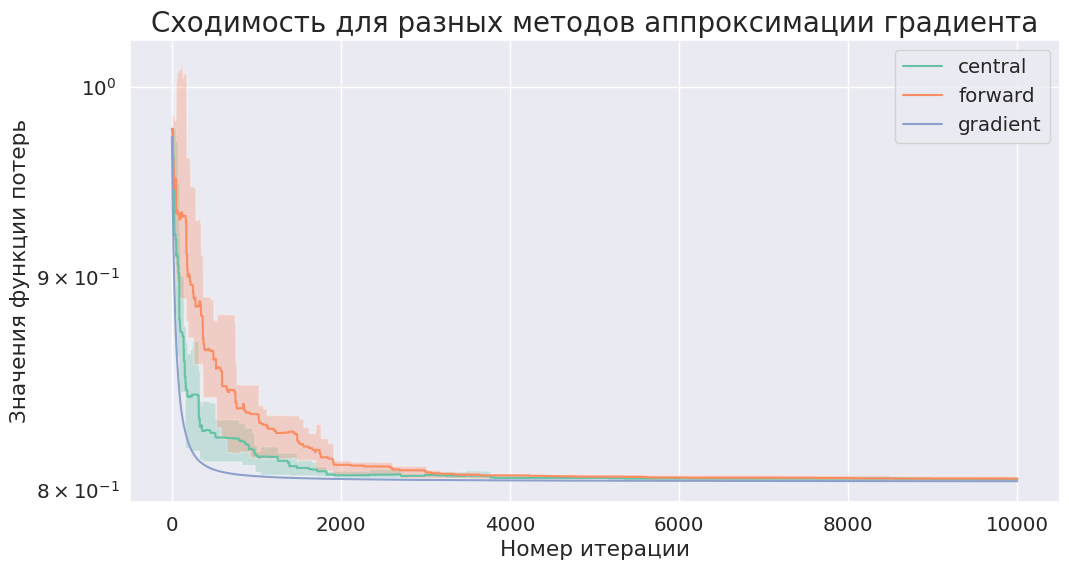

In [209]:
plot_loss_by_step_intervals(list(errors.values()), list(errors.keys()))

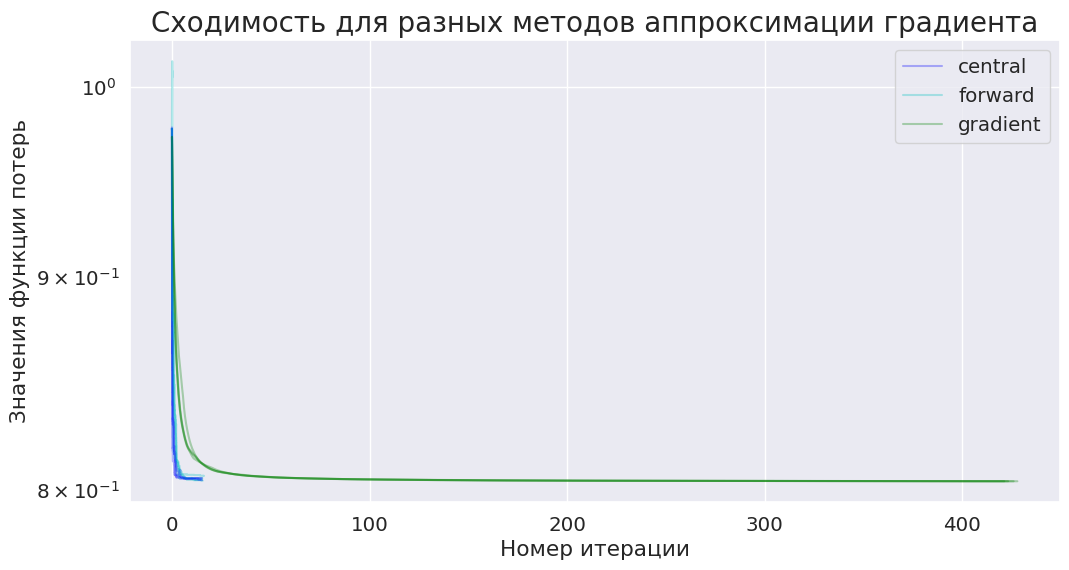

In [210]:
plot_loss_by_time_intervals(list(times.values()), list(errors.values()), list(errors.keys()))

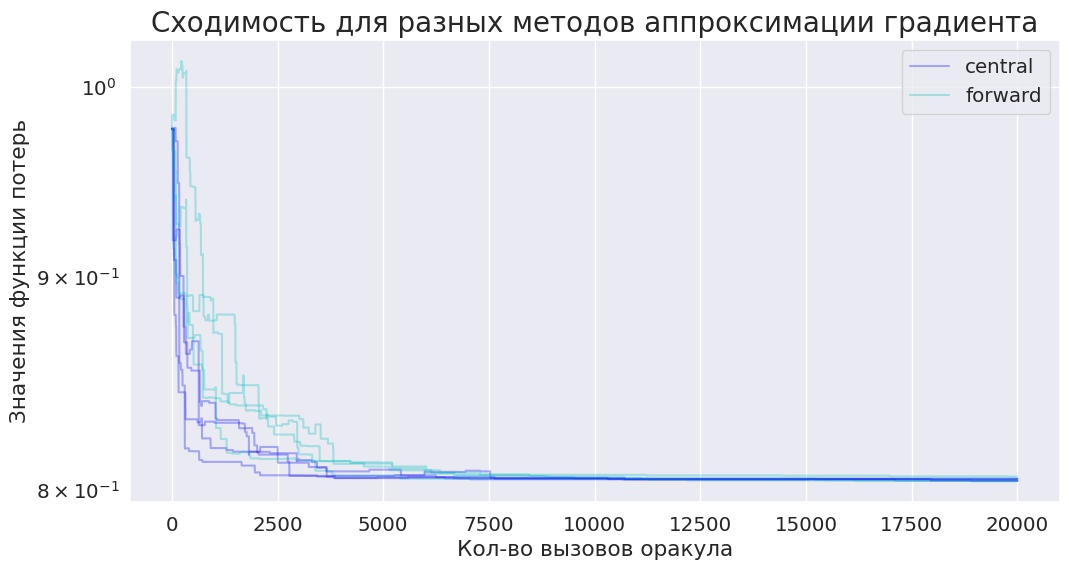

In [211]:
 plot_loss_by_oracle_calls_intervals(list(oracle_calls.values()), list(errors.values())[:-1], list(errors.keys())[:-1])